In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 100-d Gaussian mixture

In [2]:
n = 100
mu1 = jnp.ones(n) * (1.0 / 2.0)
mu2 = -mu1

stdev = 0.1
sigma = jnp.power(stdev, 2) * np.eye(n)
isigma = jnp.linalg.inv(sigma)
dsigma = jnp.linalg.det(sigma)

w1 = 0.1
w2 = 1 - w1

lower = jnp.full(n, -2)
upper = jnp.full(n, 2)

def log_like(x):
    ll1 = -0.5 * (n * jnp.log(2 * np.pi) + 
                  jnp.matmul(jnp.transpose(x - mu1), jnp.matmul(isigma, x - mu1)))
    ll2 = -0.5 * (n * jnp.log(2 * np.pi) + 
                  jnp.matmul(jnp.transpose(x - mu2), jnp.matmul(isigma, x - mu2)))
    return logsumexp(jnp.array([jnp.log(w1) + ll1, jnp.log(w2) + ll2]))

def log_prior(x, lower=lower, upper=upper):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

def prior_rvs(key, N):
    return jax.random.uniform(key, shape=(N, n), minval=lower, maxval=upper)

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_prior)

jax_prior_init = jax.random.uniform(key, shape=(400, n), minval=lower, maxval=upper)

In [3]:
mix_idx = np.random.multinomial(2000, pvals=np.array([w1, w2]))
n1_samples = n_mvn.rvs(mean=mu1, cov=sigma, size=mix_idx[0])
n2_samples = n_mvn.rvs(mean=mu2, cov=sigma, size=mix_idx[1])
truth_samples = np.concatenate((n1_samples, n2_samples))

In [4]:
'''
General parameters
'''
log_like_args = ()
log_prior_args = () 
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
random_seed = seed

'''
SINF/SNF parameters
'''
#sinf parameters
reg_alpha = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = 60
sgd_steps = 0
gamma = 0
knots_trainable = 60
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = False
Whiten_with_weights = False
iteration = None
NERCOME = False
t_ess = 0.5
MSWD_max_iter = 20
Whiten_reg = 0.98

frac_validate = 0.2
snf_loss = 3
reg = 0.0
reg1 = 0.5
reg2 = 0.5

dla_step_size = 1.0
num_extra_dla_samples = 0
grad_norm_thresh = 0.4
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
dla_beta_thresh = 0.5
latent_dla = True
maxknot = True

max_dla_burnin = 20
max_dla_iter = 100

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

Now we can run our 10d Gaussian example.

In [5]:
trace = nfmc_jax.infer_dlmc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             init_samples=jax_prior_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             #sinf parameters
                             reg_alpha=reg_alpha,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             frac_validate=frac_validate,
                             snf_loss=snf_loss,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             accelerate_dla=accelerate_dla,
                             latent_dla=latent_dla,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg,
                             max_dla_burnin=max_dla_burnin)

bounds_sinf = [[-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2], [-2, 2]]
Time for prior DLA = 2.1339111430000006


/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:547: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, R = torch.qr(ATi)


Current logZ estimate = -4662.67578125
Acceptance rate for MH adjustment: 0.8
Time for DLA MH adjustment = 4.374406266000001
Time for latent space DLA = 11.416795962000002
Current logZ estimate = -3439.776123046875
Burnin stage 1, Fisher Divergence: 445237.625
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.02292618900537491
Acceptance rate for MH adjustment: 0.455
Time for DLA MH adjustment = 3.0321214140000023
Time for latent space DLA = 6.695087199
Current logZ estimate = -2830.1298828125
Burnin stage 2, Fisher Divergence: 364718.0
Burnin stage 2, abs(norm(dlogq)/norm(dlogp)) = 0.024322781711816788
Acceptance rate for MH adjustment: 0.09
Time for DLA MH adjustment = 0.6888789339999875
Time for latent space DLA = 1.088206513000003
Current logZ estimate = -2265.227783203125
Burnin stage 3, Fisher Divergence: 286139.5625
Burnin stage 3, abs(norm(dlogq)/norm(dlogp)) = 0.02661687694489956
Acceptance rate for MH adjustment: 0.0225
Time for DLA MH adjustment = 2.7634077350000155
Time for 

Current logZ estimate = -135.39437866210938
DLA stage 8, Latent Fisher Divergence: 488.5014343261719
Primary DLA stage 8, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.4420812726020813
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.343593074999717
Time for latent space DLA = 7.38254047800001
Stage 9, Sample Mean: 0.3323312997817993
Stage 9, Sample Variance: 0.1632760763168335
Current logZ estimate = -125.13692474365234
DLA stage 9, Latent Fisher Divergence: 178.02056884765625
Primary DLA stage 9, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.4031665623188019
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.610517014999914
Time for latent space DLA = 10.277271764000034
Stage 10, Sample Mean: 0.3318180739879608
Stage 10, Sample Variance: 0.1630895435810089
Current logZ estimate = -114.8987808227539
DLA stage 10, Latent Fisher Divergence: 92.08429718017578
Primary DLA stage 10, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.46921613812446594
Acceptance rate for MH adjustment: 0.0
Time fo

Current logZ estimate = -130.4877471923828
DLA stage 29, Latent Fisher Divergence: 57.41266632080078
Primary DLA stage 29, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.3127516508102417
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.139316986999802
Time for latent space DLA = 7.4625618079999185
Stage 30, Sample Mean: 0.3272036015987396
Stage 30, Sample Variance: 0.14805558323860168
Current logZ estimate = -131.92892456054688
DLA stage 30, Latent Fisher Divergence: 55.66303634643555
Primary DLA stage 30, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.30638328194618225
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.0658677189999253
Time for latent space DLA = 7.456606928999918
Stage 31, Sample Mean: 0.32689616084098816
Stage 31, Sample Variance: 0.14749938249588013
Current logZ estimate = -132.54000854492188
DLA stage 31, Latent Fisher Divergence: 52.02595138549805
Primary DLA stage 31, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.25692859292030334
Acceptance rate for MH adjustment: 

Current logZ estimate = -108.83539581298828
DLA stage 50, Latent Fisher Divergence: 31.202011108398438
Primary DLA stage 50, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.39979252219200134
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.8782742349999353
Time for latent space DLA = 6.68560641699969
Stage 51, Sample Mean: 0.33032047748565674
Stage 51, Sample Variance: 0.1397084891796112
Current logZ estimate = -106.28849029541016
DLA stage 51, Latent Fisher Divergence: 31.188276290893555
Primary DLA stage 51, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.4171455204486847
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.8720660160001898
Time for latent space DLA = 6.5942265230000885
Stage 52, Sample Mean: 0.3304293751716614
Stage 52, Sample Variance: 0.13937489688396454
Current logZ estimate = -101.21520233154297
DLA stage 52, Latent Fisher Divergence: 30.82802963256836
Primary DLA stage 52, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.43295347690582275
Acceptance rate for MH adjustment

Current logZ estimate = -74.56724548339844
DLA stage 71, Latent Fisher Divergence: 26.384485244750977
Primary DLA stage 71, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5944077372550964
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.7765462919996935
Time for latent space DLA = 6.783815273000073
Stage 72, Sample Mean: 0.33235135674476624
Stage 72, Sample Variance: 0.1358516961336136
Current logZ estimate = -73.38465881347656
DLA stage 72, Latent Fisher Divergence: 27.277708053588867
Primary DLA stage 72, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5927309989929199
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.8334025399999518
Time for latent space DLA = 7.587223761000132
Stage 73, Sample Mean: 0.3322713077068329
Stage 73, Sample Variance: 0.13573066890239716
Current logZ estimate = -71.87596130371094
DLA stage 73, Latent Fisher Divergence: 27.149456024169922
Primary DLA stage 73, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5990120768547058
Acceptance rate for MH adjustment: 0.

Current logZ estimate = -72.881103515625
DLA stage 92, Latent Fisher Divergence: 26.775026321411133
Primary DLA stage 92, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5767492651939392
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.8561694339996393
Time for latent space DLA = 7.258411214999796
Stage 93, Sample Mean: 0.3324204981327057
Stage 93, Sample Variance: 0.13533993065357208
Current logZ estimate = -73.46128845214844
DLA stage 93, Latent Fisher Divergence: 27.851747512817383
Primary DLA stage 93, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5989661812782288
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.8274274750001496
Time for latent space DLA = 7.329433916000198
Stage 94, Sample Mean: 0.3324083387851715
Stage 94, Sample Variance: 0.13533233106136322
Current logZ estimate = -73.61827087402344
DLA stage 94, Latent Fisher Divergence: 29.561546325683594
Primary DLA stage 94, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.5876355171203613
Acceptance rate for MH adjustment: 0.0


The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [6]:
'''
f = open('./paper_experiments/gauss_mix_100d_trace.pkl', 'wb')
pickle.dump(trace, f)
f.close()
'''

"\nf = open('./paper_experiments/gauss_mix_100d_trace.pkl', 'wb')\npickle.dump(trace, f)\nf.close()\n"

In [7]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [8]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'burnin_1', 'burnin_2', 'burnin_3', 'burnin_4', 'burnin_5', 'burnin_6', 'burnin_7', 'burnin_8', 'burnin_9', 'burnin_10', 'burnin_11', 'burnin_12', 'burnin_13', 'burnin_14', 'burnin_15', 'burnin_16', 'burnin_17', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21', 'DLA_22', 'DLA_23', 'DLA_24', 'DLA_25', 'DLA_26', 'DLA_27', 'DLA_28', 'DLA_29', 'DLA_30', 'DLA_31', 'DLA_32', 'DLA_33', 'DLA_34', 'DLA_35', 'DLA_36', 'DLA_37', 'DLA_38', 'DLA_39', 'DLA_40', 'DLA_41', 'DLA_42', 'DLA_43', 'DLA_44', 'DLA_45', 'DLA_46', 'DLA_47', 'DLA_48', 'DLA_49', 'DLA_50', 'DLA_51', 'DLA_52', 'DLA_53', 'DLA_54', 'DLA_55', 'DLA_56', 'DLA_57', 'DLA_58', 'DLA_59', 'DLA_60', 'DLA_61', 'DLA_62', 'DLA_63', 'DLA_64', 'DLA_65', 'DLA_66', 'DLA_67', 'DLA_68', 'DLA_69', 'DLA_70', 'DLA_71', 'DLA_72', 'DLA_73', 'DLA_74', 'DLA_75', 'DLA_76', 'DLA

# Plotting

In [9]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='DLMC', 
                 truth_label='Target', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    
    labels = []
    
    if truth_samples is not None:
        
        truth_samples = np.asarray(truth_samples)
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    
        for i in range(len(q_samples)):
            labels.append(q_label)
        for i in range(len(truth_samples)):
            labels.append(truth_label)
    
    else:

        x_samples = q_samples
        weights = q_weights
        
        for i in range(len(q_samples)):
            labels.append(q_label)
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

      labels     $x_0$     $x_1$
0       DLMC  0.569228  0.499937
1       DLMC  0.473713  0.588393
2       DLMC -0.515392 -0.521112
3       DLMC  0.549309  0.494388
4       DLMC -0.363424 -0.459334
...      ...       ...       ...
2395  Target -0.580872 -0.576714
2396  Target -0.397445 -0.442417
2397  Target -0.544360 -0.284227
2398  Target -0.487654 -0.608379
2399  Target -0.544587 -0.614653

[2400 rows x 3 columns]


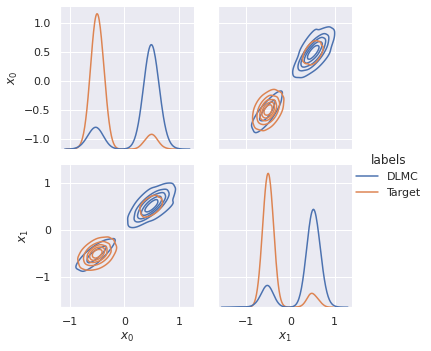

In [12]:
dla_key = 'DLA_10'

mh_samples = trace['dla_samples'][0]
x = mh_samples[dla_key]

sns_pairplot(x[:, 0:2], np.ones(len(x)), truth_samples[:, 0:2], levels=6,
             out_name=f'./dla_figs/paper/gauss_mix_100d_{dla_key}.png')

      labels     $x_0$     $x_1$
0     q_DLMC  0.606568 -0.063546
1     q_DLMC  0.948030  0.008274
2     q_DLMC -0.177554  0.852126
3     q_DLMC  0.606567  0.526764
4     q_DLMC  0.114954  0.537269
...      ...       ...       ...
3995  Target -0.580872 -0.576714
3996  Target -0.397445 -0.442417
3997  Target -0.544360 -0.284227
3998  Target -0.487654 -0.608379
3999  Target -0.544587 -0.614653

[4000 rows x 3 columns]


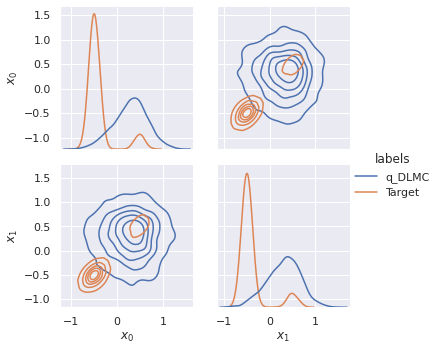

In [13]:
q_key = 'DLA_40'

q_models = trace['dla_q_models'][0]
q = q_models[q_key]

qx = q.sample(2000)
qx = qx.detach().numpy()

sns_pairplot(qx[:, 0:2], np.ones(len(qx)), truth_samples[:, 0:2], levels=6, q_label='q_DLMC')
             #out_name=f'./dla_figs/paper/strange_whiten_qfit_gauss_mix_100d_{q_key}.png')

(2000, 2)


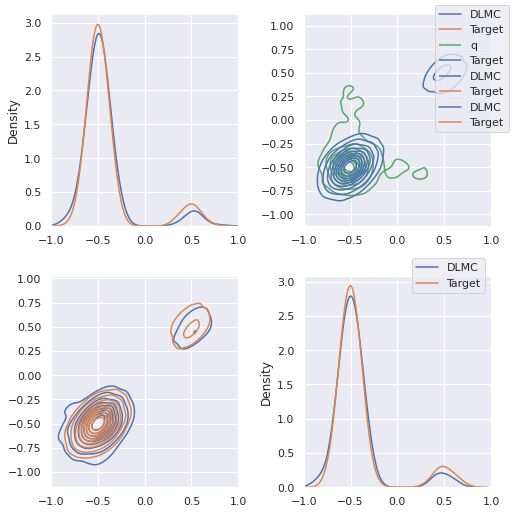

In [83]:
print(np.shape(qx[:, 0:2]))

sns.set_theme()
fig = plt.figure(figsize=(3.6 * 2, 3.6 * 2))

plt.subplot(2, 2, 1)
sns.kdeplot(x[:, 0], label='DLMC')
sns.kdeplot(truth_samples[:, 0], label='Target')
plt.xlim(-1, 1)

plt.subplot(2, 2, 2)
sns.kdeplot(x=qx[:, 1], y=qx[:, 0], label='q', color='r')
sns.kdeplot(x=truth_samples[:, 1], y=truth_samples[:, 0], label='Target')
plt.xlim(-1, 1)

plt.subplot(2, 2, 3)
sns.kdeplot(x=x[:, 0], y=x[:, 1], label='DLMC')
sns.kdeplot(x=truth_samples[:, 0], y=truth_samples[:, 1], label='Target')
plt.xlim(-1, 1)

plt.subplot(2, 2, 4)
sns.kdeplot(x[:, 1], label='DLMC')
sns.kdeplot(truth_samples[:, 1], label='Target')
plt.xlim(-1, 1)



plt.tight_layout()


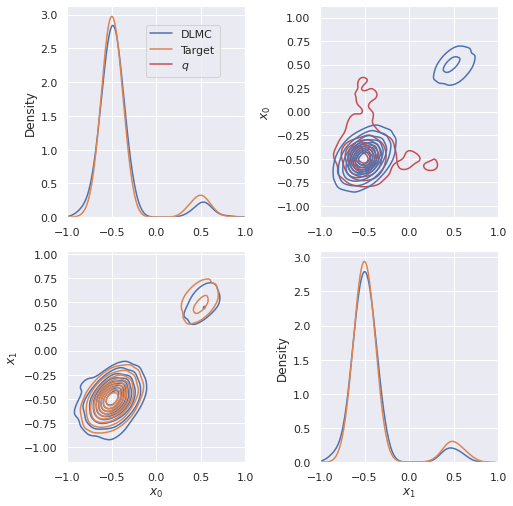

In [131]:
sns.set_theme()

fig, axlist = plt.subplots(2, 2, figsize=(3.6 * 2, 3.6 * 2))

for i, ax in enumerate(axlist.flatten()):
    
    if i == 0:
        sns.kdeplot(x[:, 0], label='DLMC', ax=ax)
        sns.kdeplot(truth_samples[:, 0], label='Target', ax=ax)
        ax.plot(-2, 0, color='r', label=r'$q$')
        ax.set_xlim(-1, 1)
    if i == 1:
        sns.kdeplot(x=qx[:, 1], y=qx[:, 0], label=r'$q$', color='r', ax=ax)
        sns.kdeplot(x=truth_samples[:, 1], y=truth_samples[:, 0], label='Target', ax=ax)
        ax.plot(-2, 0, color='r', label=r'$q$')
        ax.set_xlim(-1, 1)
        ax.set_ylabel(r'$x_0$')
    if i == 2:
        sns.kdeplot(x=x[:, 0], y=x[:, 1], label='DLMC', ax=ax)
        sns.kdeplot(x=truth_samples[:, 0], y=truth_samples[:, 1], label='Target', ax=ax)
        ax.plot(-2, 0, color='r', label=r'$q$')
        ax.set_xlim(-1, 1)
        ax.set_xlabel(r'$x_0$')
        ax.set_ylabel(r'$x_1$')
    if i == 3:
        sns.kdeplot(x[:, 1], label='DLMC', ax=ax)
        sns.kdeplot(truth_samples[:, 1], label='Target', ax=ax)
        ax.plot(-2, 0, color='r', label=r'$q$')
        ax.set_xlim(-1, 1)
        ax.set_xlabel(r'$x_1$')
        handles, labels = ax.get_legend_handles_labels()
        
'''
fig.subplots_adjust(left=0.35)
axlist.flatten()[-2].legend(loc='right', bbox_to_anchor=(2.75, 1), ncol=1)
'''
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.35, 0.95))
plt.tight_layout()


plt.savefig('./dla_figs/paper/gauss_mix_DLA_10_plusq.png')

      labels     $x_0$     $x_1$
0       DLMC -0.183356 -0.483289
1       DLMC  0.343106  0.456420
2       DLMC  0.316642  0.412467
3       DLMC  0.602016  0.448976
4       DLMC -0.513338 -0.611263
...      ...       ...       ...
2775  Target -0.580872 -0.576714
2776  Target -0.397445 -0.442417
2777  Target -0.544360 -0.284227
2778  Target -0.487654 -0.608379
2779  Target -0.544587 -0.614653

[2780 rows x 3 columns]


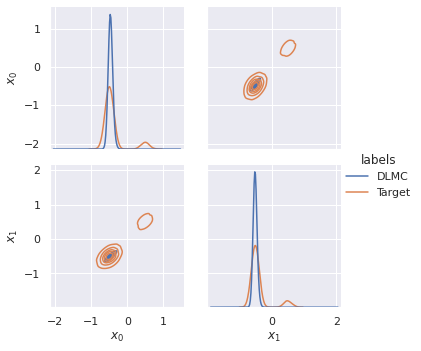

In [30]:
logqx = q.logq(torch.tensor(np.asarray(x)), dtype=torch.float32)
logqx = logqx.detach().numpy()


llk = jax.vmap(lambda z: log_like(z))(x)
lpr = jax.vmap(lambda z: log_prior(z))(x)

logw = llk + lpr - logqx
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

sns_pairplot(x[:, 0:2], iw, truth_samples[:, 0:2], levels=6)

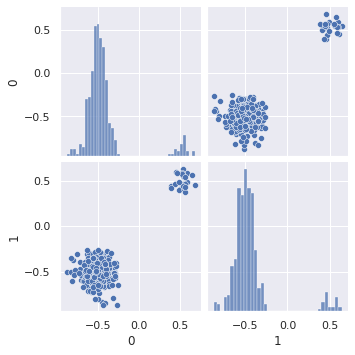

In [58]:
sns.pairplot(pd.DataFrame(x[:, 0:2]))

In [13]:
np.savetxt('./dla_figs/paper/strange_gauss_mix_100d_samples.txt', x)